# NeuroMANCER demonstration: MARS review

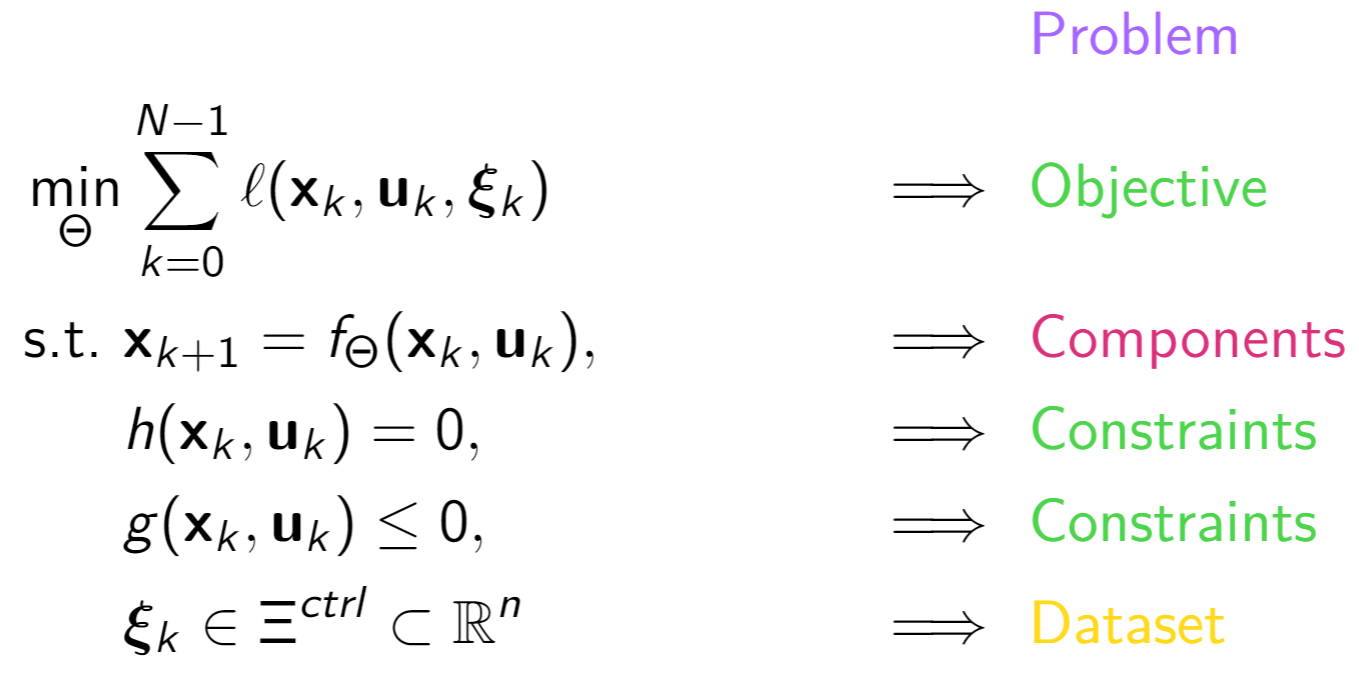

In [1]:
from IPython.display import Image
import warnings
Image('../figs/Problem_neuromancer4.PNG', width=500)

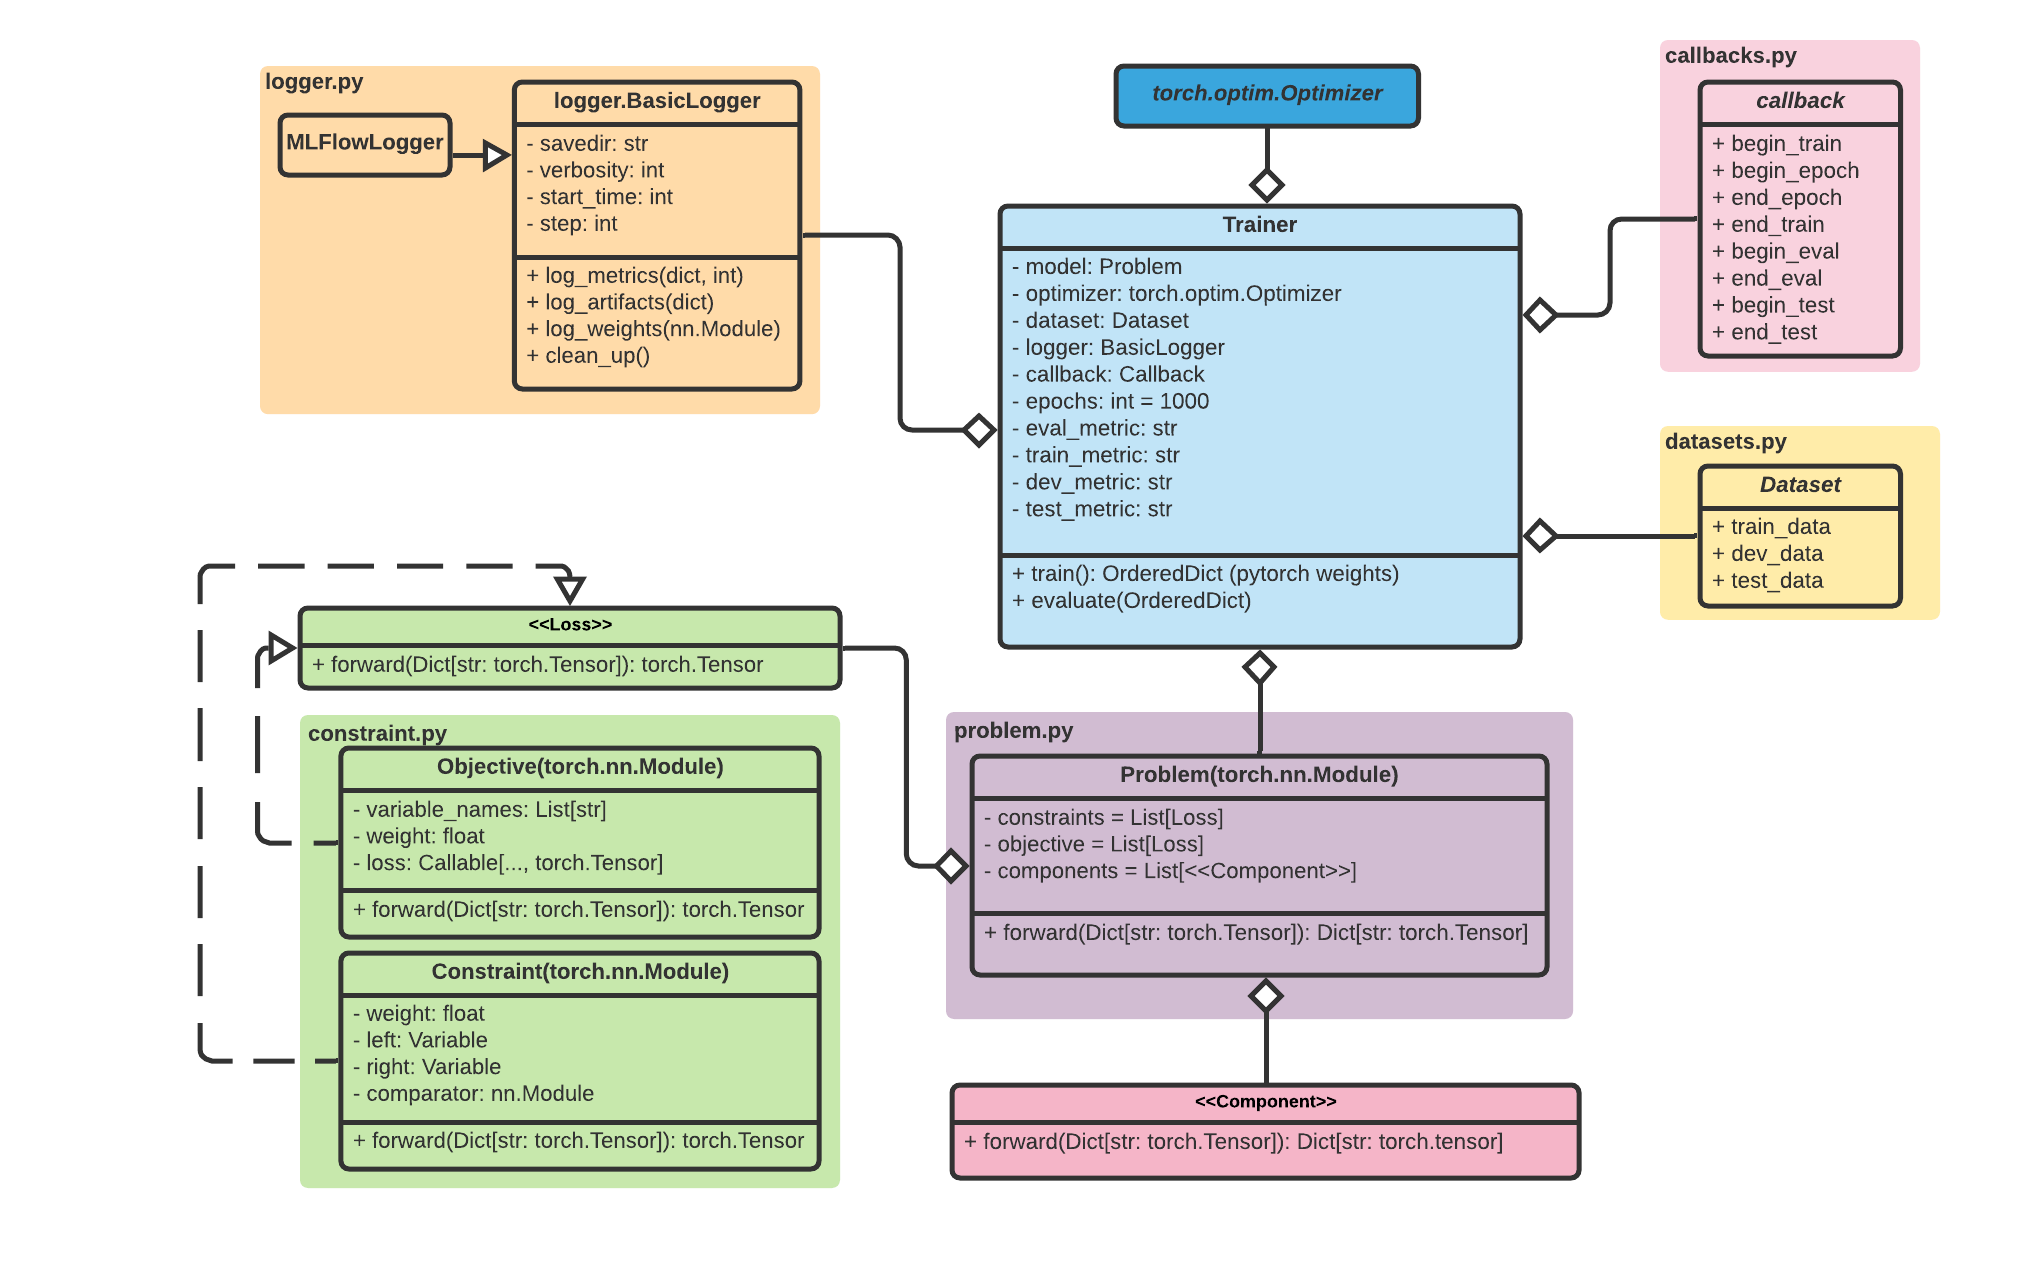

In [2]:
from neuromancer.datasets import FileDataset
from neuromancer.estimators import LinearEstimator
from neuromancer.blocks import Linear, ResMLP, MLP
from neuromancer.dynamics import BlockSSM
from neuromancer.problem import Problem
from neuromancer.simulators import OpenLoopSimulator
from neuromancer.loggers import MLFlowLogger
from neuromancer.visuals import VisualizerOpen
from neuromancer.trainer import Trainer
from neuromancer.activations import SoftExponential
from neuromancer.constraint import Variable, Objective
from neuromancer.callbacks import SysIDCallback
from argparse import Namespace

import slim 
import torch

warnings.filterwarnings("ignore")
Image('../figs/class_diagram.png')

# System ID

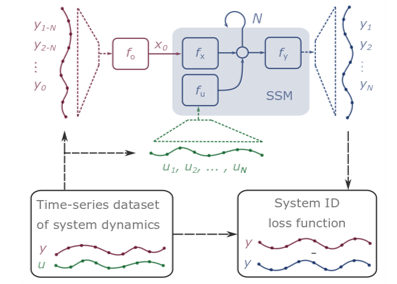

In [3]:
Image('../figs/sysid.png')

## Datasets


In [4]:
dataset = FileDataset(system="aero", 
                      nsteps=8,
                      norm=["Y", "U"])

ny = dataset.dims["Yf"][-1]
nu = dataset.dims["Uf"][-1]
nx = 64
print({k:v.shape for k, v in dataset.train_data.items()})

{'Yp': torch.Size([8, 20, 5]), 'Yf': torch.Size([8, 20, 5]), 'Up': torch.Size([8, 20, 10]), 'Uf': torch.Size([8, 20, 10])}


## State Estimator

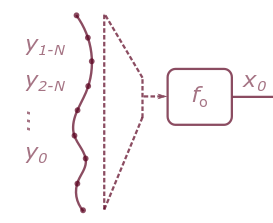

In [5]:
Image('../figs/state_estimator.png', width=200)

In [6]:
# create an estimator for initial system states
dims = {**dataset.dims, "x0": (nx,)}
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)

## State Space Model

Block-structured state space models decouple the dynamics of exogenous inputs, state transitions, and system measurements. 

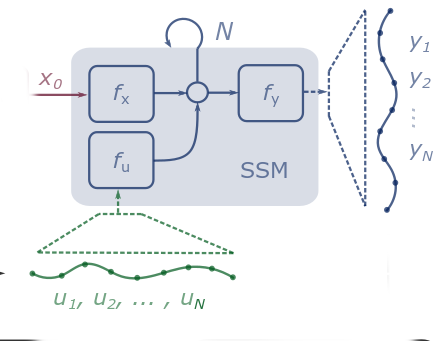

In [7]:
Image('../figs/ssm.png', width=300)

In [8]:
# define state transition map
fx = Linear(nx, nx)

# define output map
fy = Linear(nx, ny)

# define input map
fu = Linear(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

## Objective Terms
To optimize the weights of our model, we'll use mean-squared error as our objective to minimize the error between ground-truth and neural SSM predictions.

In [9]:
predictions = Variable(f"Y_pred_{ssm.name}")
truth = Variable("Yf")

ssm_objective = (predictions == truth)^2
ssm_objective.name = 'ssm_loss'

## Optimization Problem

Now we compose an optimization problem from model components, objective terms, and constraints using NeuroMANCER's `Problem` class.

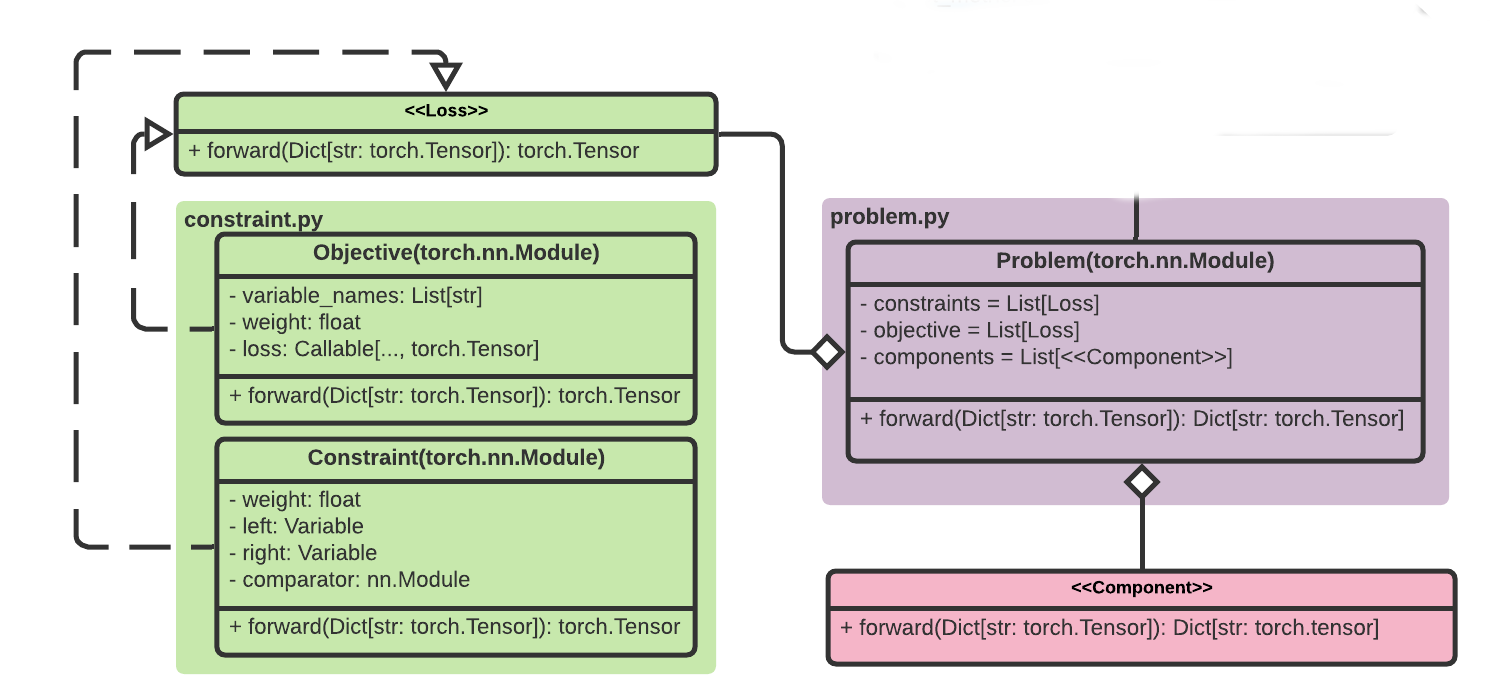

In [10]:
Image('../figs/problem_uml.png')

In [11]:
components = [state_estimator, ssm]
objectives = [ssm_objective]

constraints = []

model = Problem(objectives, constraints, components)

## Training

The `Trainer` class encapsulates boilerplate training, evaluation, and logging code, and additionally provides options for customized steps (e.g. visualizations, open loop simulations) via a Callback object. 

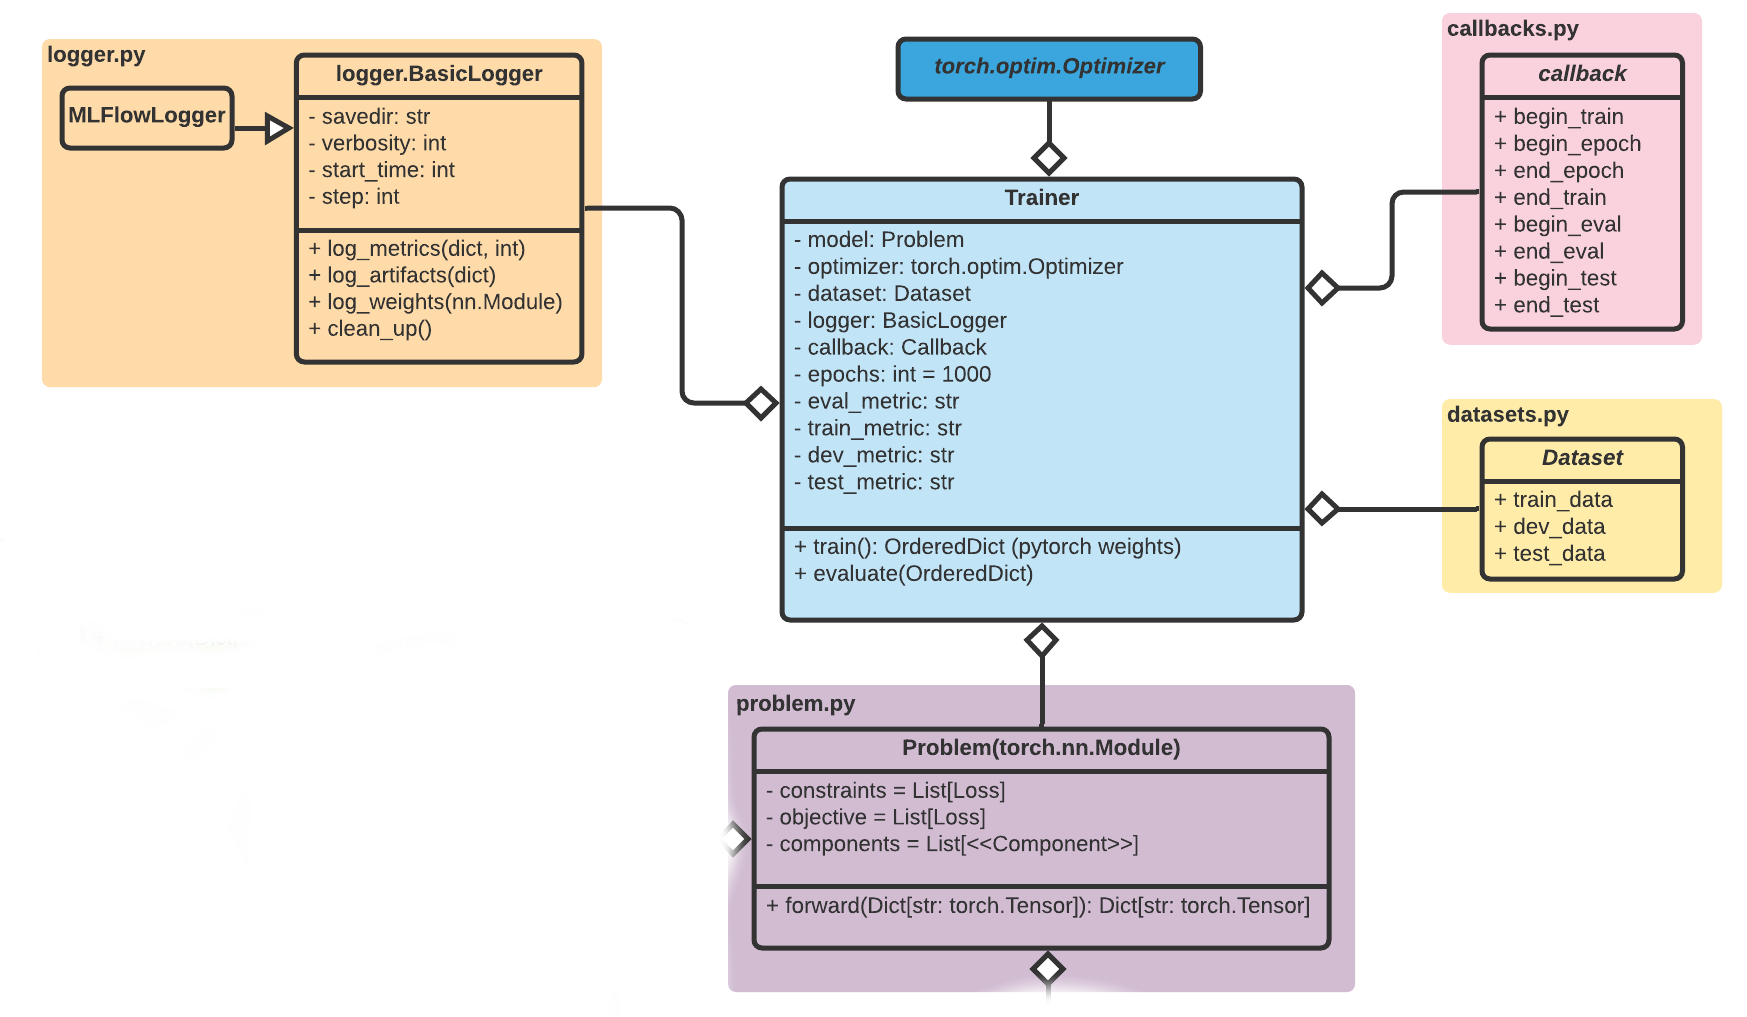

In [12]:
Image('../figs/trainer_uml.png', width=700)

In [13]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

args = Namespace()
args.location='pnl_dadaist_store'
args.exp='test'
args.run='test_run2'
logger = MLFlowLogger(args, verbosity=50,  savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=400,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )

INFO: 'test' does not exist. Creating a new experiment
Number of parameters: 10949


In [14]:
best_model = trainer.train()

epoch: 0	nstep_dev_ssm_loss: 0.58078	eltime:  2.27473
epoch: 50	nstep_dev_ssm_loss: 0.21979	eltime:  148.60385
epoch: 100	nstep_dev_ssm_loss: 0.14807	eltime:  294.20641
epoch: 150	nstep_dev_ssm_loss: 0.11011	eltime:  441.96188
epoch: 200	nstep_dev_ssm_loss: 0.09170	eltime:  605.34751
epoch: 250	nstep_dev_ssm_loss: 0.07625	eltime:  754.07978
epoch: 300	nstep_dev_ssm_loss: 0.06370	eltime:  901.86651
epoch: 350	nstep_dev_ssm_loss: 0.05388	eltime:  1056.43485


## Model Evaluation

In [ ]:
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

## Analysis of learned dynamics

In [ ]:
Image('test/eigmat.png')


## Inductive priors

In [ ]:
linargs = {'sigma_min': 1.5, 'sigma_max': 2}

fx = Linear(nx, nx, linear_map=slim.maps['pf'], linargs=linargs)

In [ ]:
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)
# define output map
fy = Linear(nx, ny)

# define input map
fu = Linear(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

model = Problem(objectives, constraints, components)
components = [state_estimator, ssm]
objectives = [ssm_objective]
constraints = []

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

logger = BasicLogger(verbosity=50, savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=1000,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )
best_model = trainer.train()
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

In [ ]:
Image('test/eigmat.png')


## Domain Aware Priors

In [ ]:
linargs = {'sigma_min': 0.1, 'sigma_max': 1.0}
fx = MLP(nx, nx, hsizes=[64, 64,64],linear_map=slim.maps['softSVD'], linargs=linargs)

reg = Variable(f'reg_error_{ssm.name}')
svd_error = (reg == 0.0)^2

Image('../figs/svd.png', width=300)

## Constraint Terms
In addition to minimizing the mean-squared error of predicted and expected observables, we may also want to impose further constraints on different model components to enforce certain model behaviors. 

In [ ]:
state_predictions = Variable(f"X_pred_{ssm.name}")
initial_states = Variable(f"x0_{state_estimator.name}")

dx_penalty = (state_predictions[1:] == state_predictions[:-1])^2

In [ ]:
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)
# define output map
fy = Linear(nx, ny)

# define input map
fu = Linear(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

model = Problem(objectives, constraints, components)
components = [state_estimator, ssm]
objectives = [ssm_objective]
constraints = [0.1*dx_penalty, 0.1*svd_error]

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

logger = BasicLogger(verbosity=50, savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=1000,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )
best_model = trainer.train()
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

In [ ]:
Image('test/eigmat.png')

## Impact

In [ ]:
Image('../figs/metrics.png')

## Transition

In [ ]:
Image('../figs/funding.png')